## 2. Structure Characterization

In [5]:
%load_ext autoreload
%autoreload 2

import os
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.ticker import ScalarFormatter
from skimage.feature import peak_local_max

from m3util.viz.layout import layout_fig, layout_subfigures_inches
from m3util.viz.text import labelfigs, add_text_to_figure
from m3util.viz.lines import draw_lines
from xrd_learn.xrd_viz import plot_xrd
from xrd_learn.xrd_utils import detect_peaks, calculate_fwhm, load_xrd_scans, align_peak_to_value, align_fwhm_center_to_value, align_peak_y_to_value, detect_fringes_thickness
from xrd_learn.rsm_viz import RSMPlotter
from afm_learn.afm_viz import AFMVisualizer
from afm_learn.afm_utils import parse_ibw, format_func
from afm_learn.afm_image_analyzer import fft2d, afm_RMS_roughness, detect_dark_holes_local_diff, fill_holes_with_mean
from sro_sto_plume.coordinate_converter import convert_top_left_origin_to_matplotlib
from sro_sto_plume.xrd_ref import calculate_2theta, plot_ref_xrd
from sro_sto_plume.packed_plot_functions import plot_xrd_figure, set_fig_axes, plot_rsm_figure, plot_fwhm_line_profile_figure, plot_fwhm_trend_figure, plot_rocking_curve_figure, plot_xrd_multiple, plot_afm_figure, plot_afm_figure_lineprofile
from plume_learn.plume_utils.viz import set_labels

# from m3util.viz.style import set_style
from m3util.viz.printing import printer
printing = printer(basepath = '../figures/', fileformats=['png', 'svg', 'tif'], dpi=600)


colors = colormaps.get_cmap('tab10').colors[:6]
sample_IDs = ['YG065', 'YG066', 'YG067', 'YG068', 'YG069', 'YG063']
sample_names = ['G1', 'G2', 'G3', 'G4', 'G5', 'C-G6']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_2388002/2227544278.py:29: DeprecationWarning: The 'printer' class/function has been renamed to 'Printer'. Please update your code.
  printing = printer(basepath = '../figures/', fileformats=['png', 'svg', 'tif'], dpi=600)


G1: Qx_target=0.0000nm, Qz_target=3.1818nm
G2: Qx_target=0.0000nm, Qz_target=3.1833nm
G3: Qx_target=0.0000nm, Qz_target=3.1842nm
G4: Qx_target=0.0007nm, Qz_target=3.1840nm
G5: Qx_target=-0.0000nm, Qz_target=3.1820nm
C-G6: Qx_target=0.0004nm, Qz_target=3.1823nm
Sample: G1, STO FWHM: 0.0445, SRO FWHM: 0.0445, peak_x[0]: 46.4721, peak_x[1]: 45.9121
Sample: G2, STO FWHM: 0.0374, SRO FWHM: 0.0374, peak_x[0]: 46.4721, peak_x[1]: 45.9121
Sample: G3, STO FWHM: 0.0433, SRO FWHM: 0.0433, peak_x[0]: 46.4721, peak_x[1]: 45.9121
Sample: G4, STO FWHM: 0.0681, SRO FWHM: 0.0681, peak_x[0]: 46.4721, peak_x[1]: 45.9121
Sample: G5, STO FWHM: 0.0308, SRO FWHM: 0.0308, peak_x[0]: 46.4721, peak_x[1]: 45.8921
Sample: C-G6, STO FWHM: 0.0815, SRO FWHM: 0.0815, peak_x[0]: 46.4721, peak_x[1]: 45.9321
G1: Qx_target=1.6127nm, Qz_target=4.7825nm
G2: Qx_target=1.6097nm, Qz_target=4.7862nm
G3: Qx_target=1.6091nm, Qz_target=4.7862nm
G4: Qx_target=1.6082nm, Qz_target=4.7859nm
G5: Qx_target=1.6094nm, Qz_target=4.7834nm


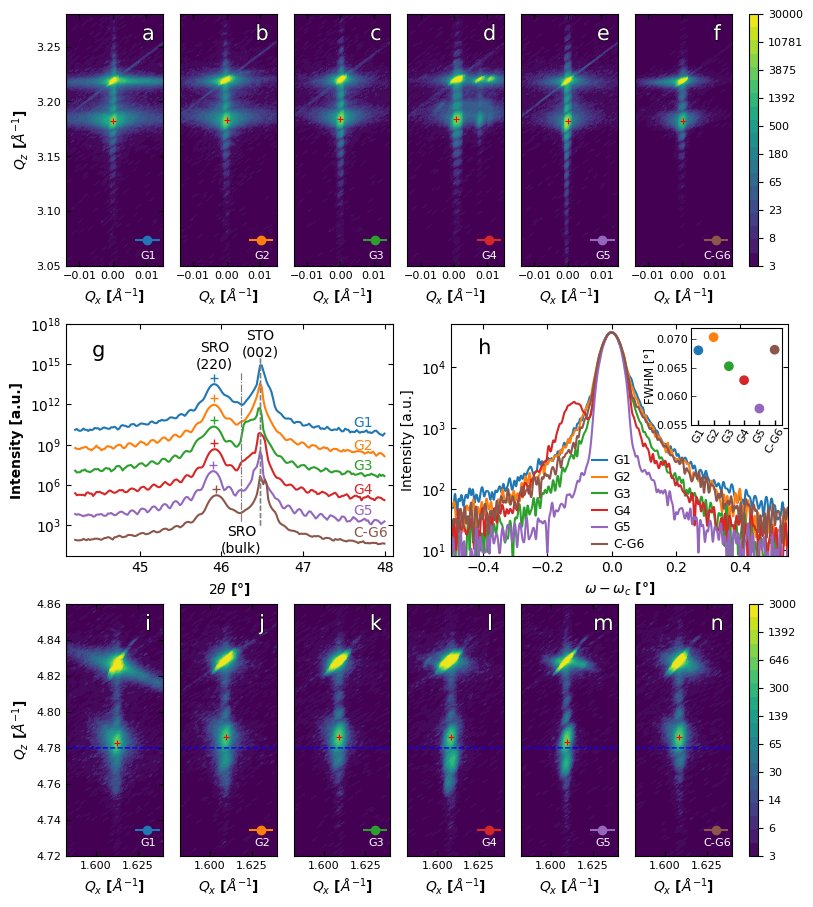

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

xrd_files = ['../data/XRD_RSM/YG065/YG065_2theta-Omega_42-49degree.xrdml',
             '../data/XRD_RSM/YG066/YG066 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
             '../data/XRD_RSM/YG067/YG067 2theta-Omega_Path1_42-49 degree_slow_2 1.xrdml',
             '../data/XRD_RSM/YG068/YG068 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
             '../data/XRD_RSM/YG069/YG069 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
             '../data/XRD_RSM/YG063/YG063_2theta-Omega_42-49degree.xrdml']
rocking_curve_files = glob.glob('../data/XRD_RSM/YG06*/YG06*Rokcing*1_32*')
rsm002_files = glob.glob('../data/XRD_RSM/YG06*/*002*.xrdml')
rsm103_files = glob.glob('../data/XRD_RSM/YG06*/*RSM-103_phi-angle4*')

fig, axes_dict = plot_xrd_multiple(xrd_files, rocking_curve_files, rsm002_files, rsm103_files, label=True)
printing.savefig(fig, 'Figure2-XRD_RSM')
plt.show()

TypeError: 'NoneType' object is not subscriptable

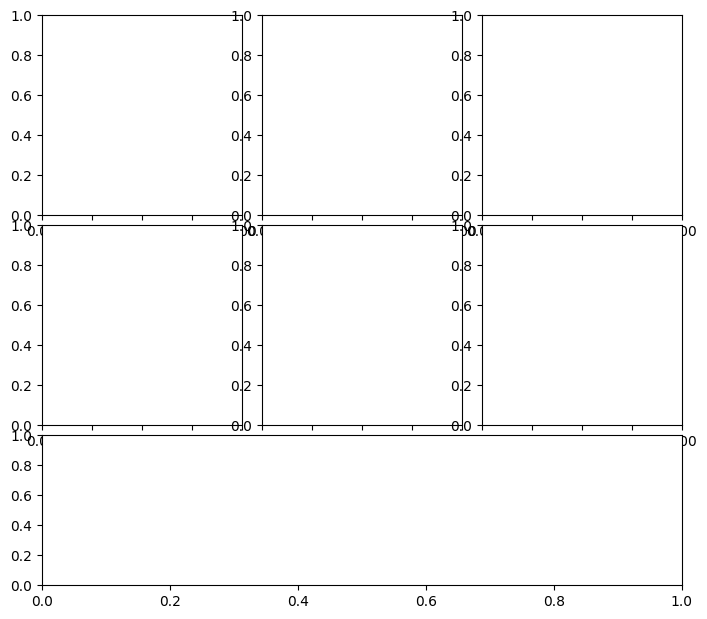

In [7]:
# AFM
files_ibw = glob.glob('../data/AFM/10um/YG*ibw')
files_ibw = sorted(files_ibw, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0])) # Sort the list using the custom order

files_txt = glob.glob('../data/AFM/10um/YG*plain.txt')
files_txt = sorted(files_txt, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0])) # Sort the list using the custom order

files_txt_roughness = glob.glob('../data/AFM/10um/YG*_remove_holes.txt')
files_txt_roughness = sorted(files_txt_roughness, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0])) # Sort the list using the custom order

afm_visualizer = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (2, 98), 'outliers_std': 5, 'symmetric_clim':True, 'visible': True}, zero_mean=False, scalebar=True, debug=False)

fig, axes_dict = plot_afm_figure(afm_visualizer, files_ibw, files_txt, files_txt_roughness, sample_names, colors=colors, plot_roughness=True, roughness_ylim=(-0.05, 1), roughness_label_loc='br')
printing.savefig(fig, 'Figure3-AFM_10um')
plt.show()

TypeError: 'NoneType' object is not subscriptable

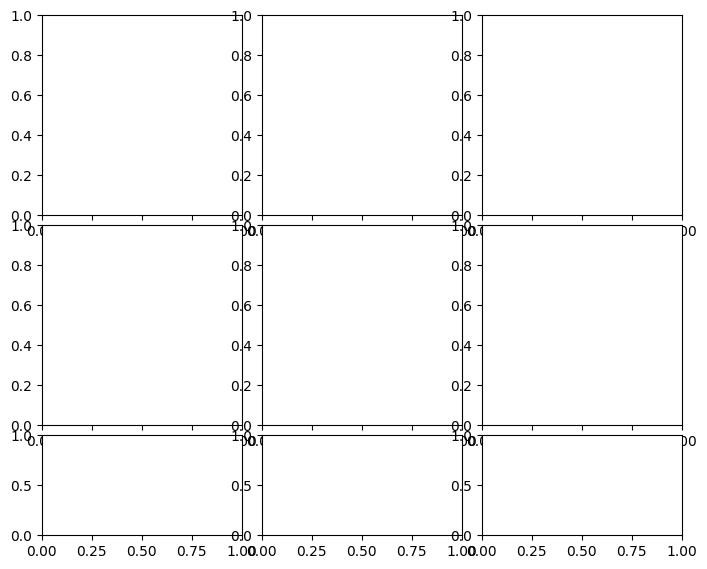

In [8]:
files_ibw = glob.glob('../data/AFM/5um/YG*ibw')
files_ibw = sorted(files_ibw, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0])) # Sort the list using the custom order

files_txt = glob.glob('../data/AFM/5um/YG*txt')
files_txt = sorted(files_txt, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0])) # Sort the list using the custom order

line_ax_indexes = [1, 2, 5]
line_profile_txt = ['../data/AFM/5um/flat_YG066_0018.txt', '../data/AFM/5um/flat_YG067_0189.txt', '../data/AFM/5um/flat_YG063_0045.txt']
line_coords = [((95, 80), (190, 190)), ((112, 100), (180, 152)), ((117, 19), (157, 44))]

afm_visualizer = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (1, 99), 'outliers_std': 5, 'symmetric_clim':True, 'visible': True}, zero_mean=False, scalebar=True, debug=False)
fig, axes_dict = plot_afm_figure_lineprofile(afm_visualizer, files_ibw, files_txt, sample_names, colors, line_ax_indexes, line_profile_txt, line_coords)
printing.savefig(fig, 'FigureS1-AFM_5um_lineprofile')
plt.show()

### Detailed Figure and statistics

#### calculate thickness

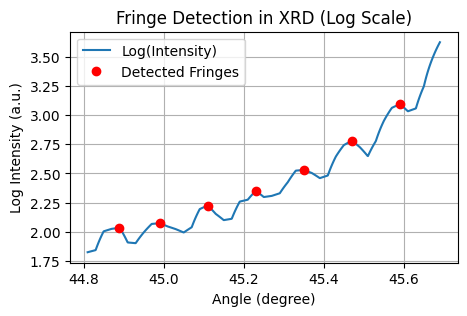

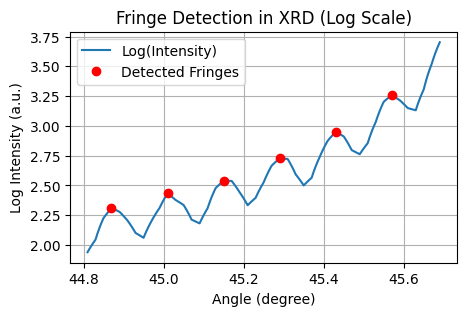

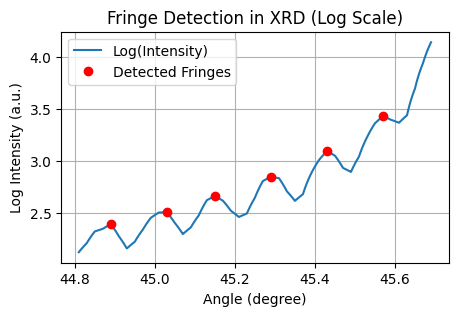

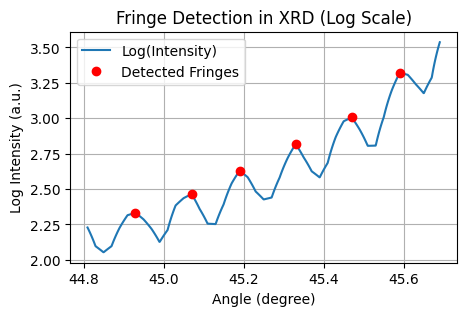

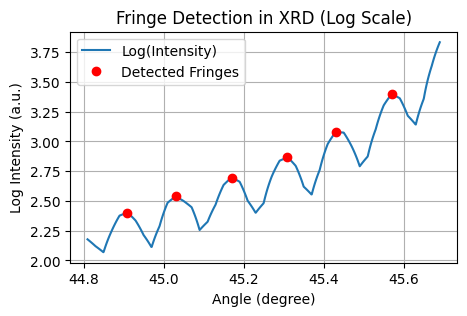

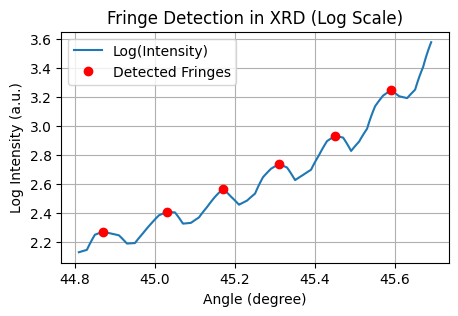

YG065: 82.29±5.74 nm
YG066: 68.27±0.05 nm
YG067: 70.55±4.33 nm
YG068: 72.75±5.32 nm
YG069: 72.74±5.29 nm
YG063: 66.64±3.53 nm


In [9]:
files = ['../data/XRD_RSM/YG065/YG065_2theta-Omega_42-49degree.xrdml',
        '../data/XRD_RSM/YG066/YG066 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG067/YG067 2theta-Omega_Path1_42-49 degree_slow_2 1.xrdml',
        '../data/XRD_RSM/YG068/YG068 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG069/YG069 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG063/YG063_2theta-Omega_42-49degree.xrdml',]

Xs, Ys, length_list = load_xrd_scans(files)
thickenss = {}
for (X, Y, file) in zip(Xs, Ys, files):
    filename = os.path.basename(file)
    results = detect_fringes_thickness(X, Y, mode="peak", fringe_range=(44.8, 45.7), prominence=0.05, min_distance_deg=0.1)
    thickenss[filename[:5]] = results['Peak Find Thickness (nm)']
    
for name, thickness in thickenss.items():
    print(f"{name}: {np.mean(thickenss[name]):.2f}±{np.std(thickenss[name]):.2f} nm")

##### calculate roughness

Processing YG065_0006-plain.txt...


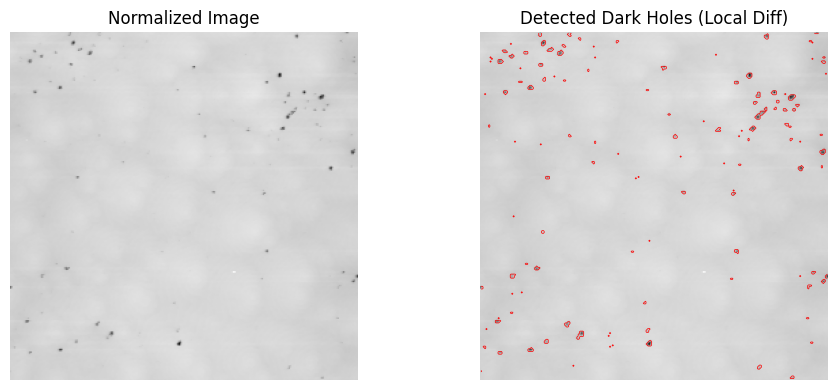

RMS Roughness (original): 1.1657e-09
RMS Roughness (holes replaced): 7.8346e-10
{'hole_count': 125, 'total_area': np.int64(547), 'avg_area': np.float64(4.376), 'density': 0.0019073486328125, 'hole_ratio': np.float64(0.0083465576171875)}
Processing YG066_0017-plain.txt...


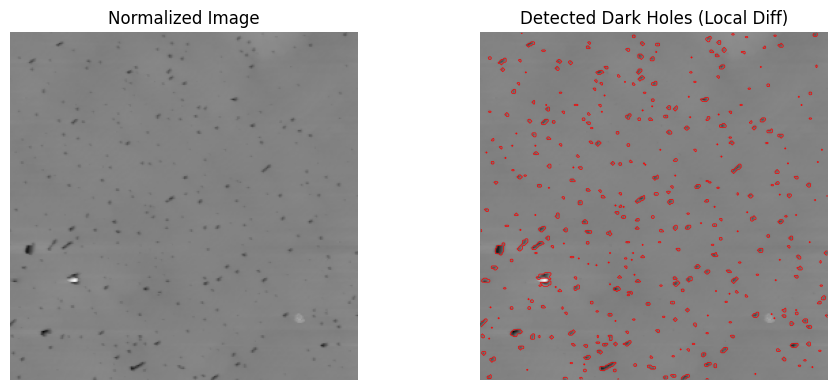

RMS Roughness (original): 1.3368e-09
RMS Roughness (holes replaced): 6.4620e-10
{'hole_count': 377, 'total_area': np.int64(1959), 'avg_area': np.float64(5.196286472148541), 'density': 0.0057525634765625, 'hole_ratio': np.float64(0.0298919677734375)}
Processing YG067_0188-plain.txt...


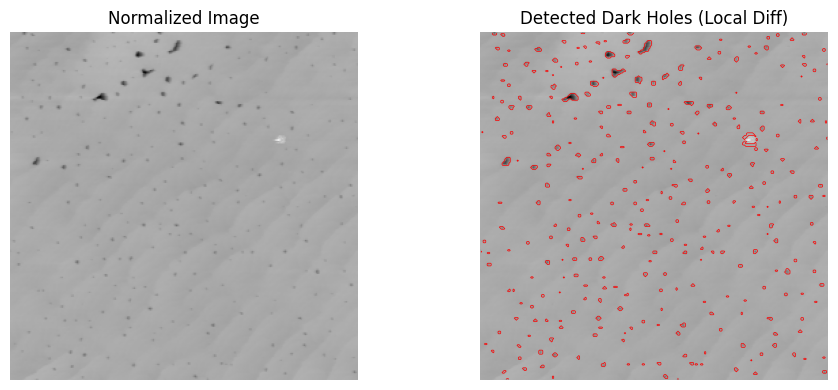

RMS Roughness (original): 1.0699e-09
RMS Roughness (holes replaced): 5.5611e-10
{'hole_count': 308, 'total_area': np.int64(1573), 'avg_area': np.float64(5.107142857142857), 'density': 0.00469970703125, 'hole_ratio': np.float64(0.0240020751953125)}
Processing YG068_0012-plain.txt...


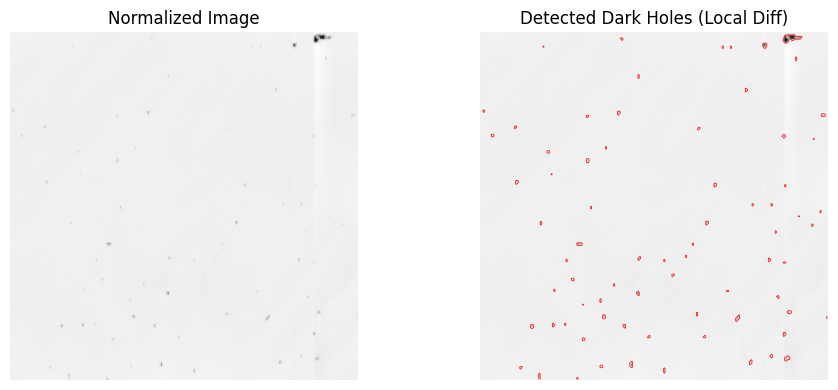

RMS Roughness (original): 1.0915e-09
RMS Roughness (holes replaced): 3.4444e-10
{'hole_count': 73, 'total_area': np.int64(308), 'avg_area': np.float64(4.219178082191781), 'density': 0.0011138916015625, 'hole_ratio': np.float64(0.00469970703125)}
Processing YG069_0023-plain.txt...


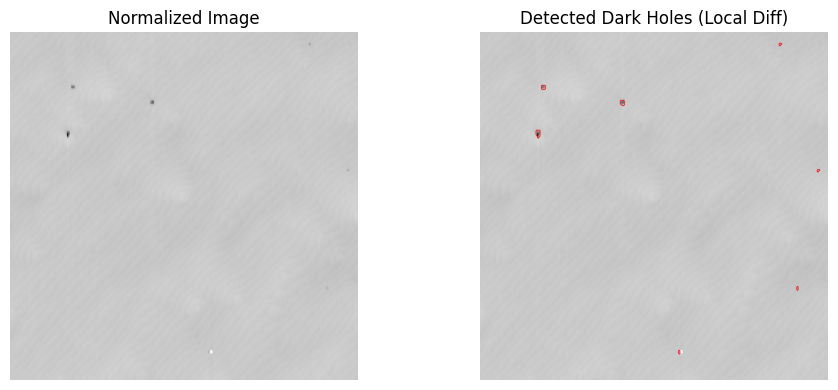

RMS Roughness (original): 2.3115e-10
RMS Roughness (holes replaced): 1.9439e-10
{'hole_count': 7, 'total_area': np.int64(47), 'avg_area': np.float64(6.714285714285714), 'density': 0.0001068115234375, 'hole_ratio': np.float64(0.0007171630859375)}
Processing YG063_0044-plain.txt...


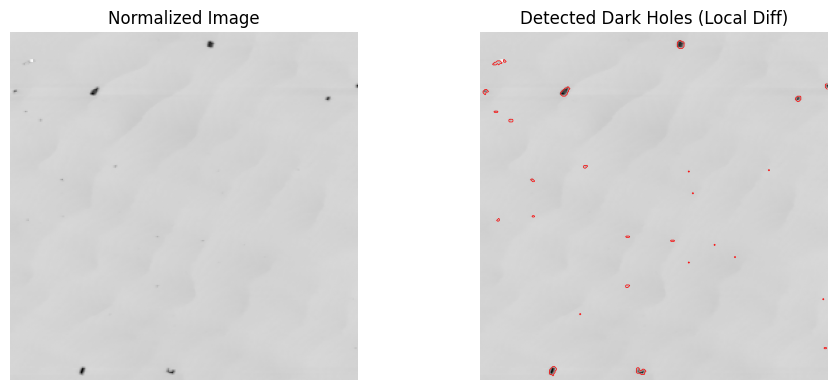

RMS Roughness (original): 1.2603e-09
RMS Roughness (holes replaced): 5.2223e-10
{'hole_count': 27, 'total_area': np.int64(186), 'avg_area': np.float64(6.888888888888889), 'density': 0.0004119873046875, 'hole_ratio': np.float64(0.002838134765625)}
YG065_0006-plain.txt: 0.83%
YG066_0017-plain.txt: 2.99%
YG067_0188-plain.txt: 2.40%
YG068_0012-plain.txt: 0.47%
YG069_0023-plain.txt: 0.07%
YG063_0044-plain.txt: 0.28%


In [10]:
files_txt = glob.glob('../data/AFM/10um/YG*plain.txt')
files_txt = sorted(files_txt, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0])) # Sort the list using the custom order

hole_ratio_dict = {}
for file in files_txt:
    filename = os.path.basename(file)
    print(f"Processing {filename}...")
    image = np.loadtxt(file)
    mask, stats = detect_dark_holes_local_diff(image, window_size=11, threshold=0.025)
    
    # Fill hole regions
    image_filled = fill_holes_with_mean(image, mask)

    # Compute roughness
    rms = afm_RMS_roughness(image)
    print(f"RMS Roughness (original): {rms:.4e}")
    
    # Compute roughness
    rms = afm_RMS_roughness(image_filled)
    print(f"RMS Roughness (holes replaced): {rms:.4e}")

    # Save masked-and-filled image (optional)
    
    base, ext = os.path.splitext(file)
    file_new = f"{base}_remove_holes{ext}"
    np.savetxt(file_new, image_filled)
    print(stats)
    hole_ratio_dict[filename] = stats['hole_ratio']

for name, ratio in hole_ratio_dict.items():
    print(f"{name}: {ratio*100:.2f}%")

#### XRD and RSM

G1: Qx_target=0.0000nm, Qz_target=3.1818nm
G2: Qx_target=0.0000nm, Qz_target=3.1833nm
G3: Qx_target=0.0000nm, Qz_target=3.1842nm
G4: Qx_target=0.0007nm, Qz_target=3.1840nm
G5: Qx_target=-0.0000nm, Qz_target=3.1820nm
C-G6: Qx_target=0.0004nm, Qz_target=3.1823nm
Sample: G1, STO FWHM: 0.0445, SRO FWHM: 0.0445, peak_x[0]: 46.4721, peak_x[1]: 45.9121
Sample: G2, STO FWHM: 0.0374, SRO FWHM: 0.0374, peak_x[0]: 46.4721, peak_x[1]: 45.9121
Sample: G3, STO FWHM: 0.0433, SRO FWHM: 0.0433, peak_x[0]: 46.4721, peak_x[1]: 45.9121
Sample: G4, STO FWHM: 0.0681, SRO FWHM: 0.0681, peak_x[0]: 46.4721, peak_x[1]: 45.9121
Sample: G5, STO FWHM: 0.0308, SRO FWHM: 0.0308, peak_x[0]: 46.4721, peak_x[1]: 45.8921
Sample: C-G6, STO FWHM: 0.0815, SRO FWHM: 0.0815, peak_x[0]: 46.4721, peak_x[1]: 45.9321
G1: Qx_target=1.6127nm, Qz_target=4.7825nm
G2: Qx_target=1.6097nm, Qz_target=4.7862nm
G3: Qx_target=1.6091nm, Qz_target=4.7862nm
G4: Qx_target=1.6082nm, Qz_target=4.7859nm
G5: Qx_target=1.6094nm, Qz_target=4.7834nm


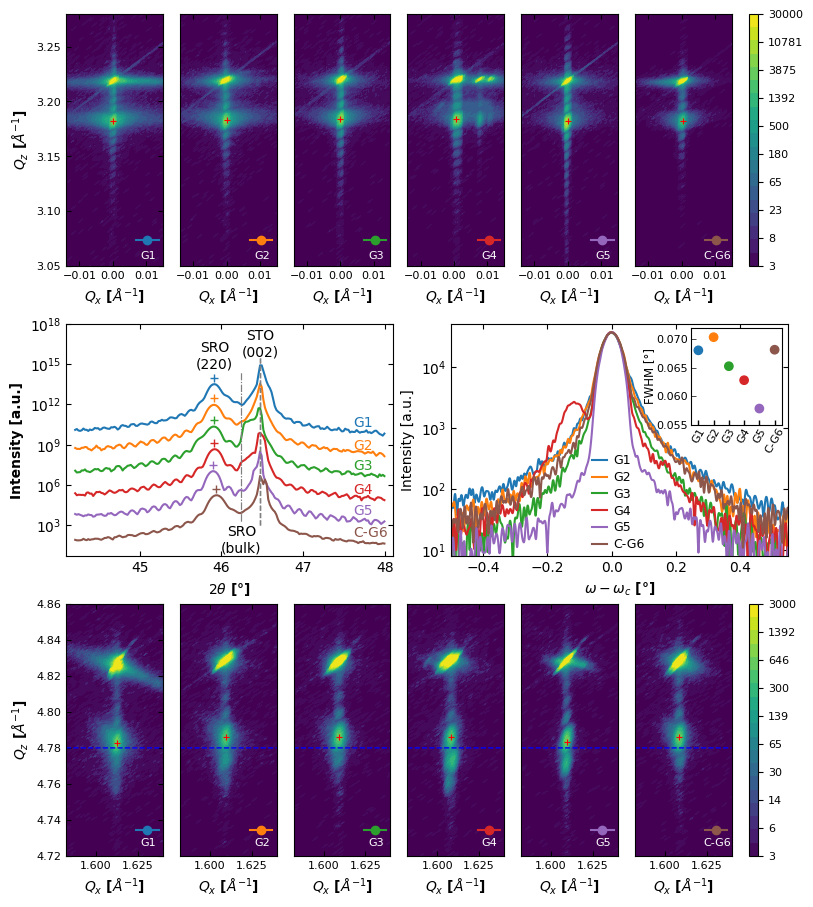

In [11]:
fig, axes_dict = plot_xrd_multiple(xrd_files, rocking_curve_files, rsm002_files, rsm103_files, label=False)
printing.savefig(fig, '2-XRD-RSM-no_marks')
plt.show()

##### single figures

In [ ]:
files = ['../data/XRD_RSM/YG065/YG065_2theta-Omega_42-49degree.xrdml',
        '../data/XRD_RSM/YG066/YG066 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG067/YG067 2theta-Omega_Path1_42-49 degree_slow_2 1.xrdml',
        '../data/XRD_RSM/YG068/YG068 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG069/YG069 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG063/YG063_2theta-Omega_42-49degree.xrdml',]
fig, ax = layout_fig(graph=1, mod=1, figsize=(3.9, 3), ax=axes_dict['1_1'], layout='tight')
plot_xrd_figure(files, sample_names, fig, ax, xrange=(44.2, 48), yrange=None, title=None, filename=None)
xrange, yrange = (44.1, 48.1), (5, 1e18)
ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
labelfigs(ax, number=0, style='bw', size=15, inset_fraction=(0.99, 0.1), loc='tl')

# plt.savefig('../figures/1-XRD.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
files = glob.glob('../data/XRD_RSM/YG06*/YG06*Rokcing*1_32*')
files = sorted(files, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0]))

fig, ax = layout_fig(graph=1, mod=1, figsize=(3.9, 3), layout='tight')
plot_rocking_curve_figure(sample_names, files, fig, ax, inset_coords=[0.73, 0.65, 0.22, 0.29])
labelfigs(ax, number=1, style='bw', size=15, inset_fraction=(0.6, 0.1), loc='tl')
# plt.savefig('../figures/1-Rocking_Curve.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
# RSM 103 phi-angle4
files = glob.glob('../data/XRD_RSM/YG06*/*RSM-103_phi-angle4*')
files = sorted(files, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0]))

plot_params_103 = {"xlim": (1.582, 1.64), "ylim": (4.72, 4.86), "vmax": 3000, 'lineplot_xlim': (1.595, 1.621), 'lineplot_ylim': (-100, 900)}
plotter = RSMPlotter(plot_params_103)
graph, mod = 7, 7
width_ratios = [1, 1, 1, 1, 1, 1, 0.1]
text_locs = [(1.7+1.02*i, 0.4) for i in range(6)]

fig, axes = layout_fig(graph=graph, mod=mod, figsize=(8, 3), subplot_style='gridspec', width_ratios=width_ratios, spacing=(0.2, 0.2), layout='tight')
Qx_lines, intensity_lines = plot_rsm_figure(plotter, fig, axes, files, sample_names, cbar_ax=axes[-1], peak_z_range=(4.78, 4.80), 
                                            draw_peak=True, draw_peak_line=False, i_start=2, text_locs=text_locs)

# plt.savefig('../figures/1-RSM_103_phi_angle4.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
# (002) plane
files = glob.glob('../data/XRD_RSM/YG06*/*002*.xrdml')
files = sorted(files, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0]))

plot_params_002 = {"xlim": (-0.014, 0.015), "ylim": (3.05, 3.28), "vmax": 30000}
plotter = RSMPlotter(plot_params_002)
graph, mod = 7, 7
width_ratios = [1, 1, 1, 1, 1, 1,0.1]
text_locs = [(1.7+1.02*i, 0.4) for i in range(6)]

fig, axes = layout_fig(graph=graph, mod=mod, figsize=(8, 3), subplot_style='gridspec', width_ratios=width_ratios, spacing=(0.2, 0.2), layout='tight')
Qx_lines, intensity_lines = plot_rsm_figure(plotter, fig, axes, files, sample_names, cbar_ax=axes[-1], peak_z_range=None, 
                                            draw_peak=False, draw_peak_line=False, i_start=8, text_locs=text_locs)

# plt.savefig('../figures/1-RSM_002.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

#### AFM

In [ ]:
# AFM
files_ibw = glob.glob('../data/AFM/5um/YG*ibw')
files_ibw = sorted(files_ibw, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0])) # Sort the list using the custom order

files_txt = glob.glob('../data/AFM/5um/YG*txt') # for calculating roughness
files_txt = sorted(files_txt, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0])) # Sort the list using the custom order

files_roughness_txt = glob.glob('../data/AFM/10um/YG*txt') # for calculating roughness
files_roughness_txt = sorted(files_roughness_txt, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0]))

afm_visualizer = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (2, 98), 'outliers_std': 5, 'symmetric_clim':True, 'visible': True}, zero_mean=False, scalebar=True, debug=False)

fig, axes_dict = plot_afm_figure(afm_visualizer, files_ibw, files_txt, files_roughness_txt, sample_names, colors=colors, plot_roughness=True, roughness_ylim=(-0.05, 1.5), roughness_label_loc='br', label=True)
printing.savefig(fig, '2-AFM_5um')
# plt.savefig('../figures/S1-AFM_5um.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
# AFM
files_ibw = glob.glob('../data/AFM/5um/YG*ibw')
files_ibw = sorted(files_ibw, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0])) # Sort the list using the custom order

files_txt = glob.glob('../data/AFM/5um/YG*txt') # for calculating roughness
files_txt = sorted(files_txt, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0])) # Sort the list using the custom order

files_roughness_txt = glob.glob('../data/AFM/10um/YG*txt') # for calculating roughness
files_roughness_txt = sorted(files_roughness_txt, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0]))

afm_visualizer = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (2, 98), 'outliers_std': 5, 'symmetric_clim':True, 'visible': True}, zero_mean=False, scalebar=True, debug=False)

fig, axes_dict = plot_afm_figure(afm_visualizer, files_ibw, files_txt, files_roughness_txt, sample_names, colors=colors, plot_roughness=True, roughness_ylim=(-0.05, 1.5), roughness_label_loc='br', label=False)
printing.savefig(fig, '2-AFM_5um_no_marks')
# plt.savefig('../figures/S1-AFM_5um.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
# AFM
files_ibw = glob.glob('../data/AFM/10um/YG*ibw')
files_ibw = sorted(files_ibw, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0])) # Sort the list using the custom order

files_txt = glob.glob('../data/AFM/10um/YG*plain.txt')
files_txt = sorted(files_txt, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0])) # Sort the list using the custom order

files_txt_roughness = glob.glob('../data/AFM/10um/YG*_remove_holes.txt')
files_txt_roughness = sorted(files_txt_roughness, key=lambda x: sample_IDs.index(x.split('/')[-1].split('_')[0])) # Sort the list using the custom order

afm_visualizer = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (2, 98), 'outliers_std': 5, 'symmetric_clim':True, 'visible': True}, zero_mean=False, scalebar=True, debug=False)

fig, axes_dict = plot_afm_figure(afm_visualizer, files_ibw, files_txt, files_txt_roughness, sample_names, colors=colors, plot_roughness=True, roughness_ylim=(-0.05, 1), roughness_label_loc='br')
printing.savefig(fig, '2-AFM_10um')
# plt.savefig('../figures/S1-AFM_10um.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

##### AFM - 5um

In [ ]:
files_ibw = glob.glob('../data/AFM/5um/YG*ibw')
files_ibw = sorted(files_ibw, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0])) # Sort the list using the custom order

files_txt = glob.glob('../data/AFM/5um/YG*txt')
files_txt = sorted(files_txt, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0])) # Sort the list using the custom order

line_ax_indexes = [1, 2, 5]
line_profile_txt = ['../data/AFM/5um/flat_YG066_0018.txt', '../data/AFM/5um/flat_YG067_0189.txt', '../data/AFM/5um/flat_YG063_0045.txt']
line_coords = [((95, 80), (190, 190)), ((112, 100), (180, 152)), ((117, 19), (157, 44))]

afm_visualizer = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (1, 99), 'outliers_std': 5, 'symmetric_clim':True, 'visible': True}, zero_mean=False, scalebar=True, debug=False)
fig, axes_dict = plot_afm_figure_lineprofile(afm_visualizer, files_ibw, files_txt, sample_names, colors, line_ax_indexes, line_profile_txt, line_coords)
printing.savefig(fig, 'S1-AFM_5um_lineprofile')
# plt.savefig('../figures/2-AFM_5um.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
files_ibw = glob.glob('../data/AFM/5um/YG*ibw')
files_ibw = sorted(files_ibw, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0])) # Sort the list using the custom order

files_txt = glob.glob('../data/AFM/5um/YG*txt')
files_txt = sorted(files_txt, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0])) # Sort the list using the custom order

line_ax_indexes = [1, 2, 5]
line_profile_txt = ['../data/AFM/5um/flat_YG066_0018.txt', '../data/AFM/5um/flat_YG067_0189.txt', '../data/AFM/5um/flat_YG063_0045.txt']
line_coords = [((95, 80), (190, 190)), ((112, 100), (180, 152)), ((117, 19), (157, 44))]

afm_visualizer = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (1, 99), 'outliers_std': 5, 'symmetric_clim':True, 'visible': True}, zero_mean=False, scalebar=True, debug=False)
fig, axes_dict = plot_afm_figure_lineprofile(afm_visualizer, files_ibw, files_txt, sample_names, colors, line_ax_indexes, line_profile_txt, line_coords, label=False)
printing.savefig(fig, 'S1-AFM_5um_lineprofile-no_marks')
# plt.savefig('../figures/2-AFM_5um.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
# AFM
files_ibw = glob.glob('../data/AFM/10um/YG*ibw')
files_ibw = sorted(files_ibw, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0])) # Sort the list using the custom order

files_txt = glob.glob('../data/AFM/10um/YG*txt')
files_txt = sorted(files_txt, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0])) # Sort the list using the custom order

afm_visualizer = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (2, 98), 'outliers_std': 5, 'symmetric_clim':True, 'visible': True}, zero_mean=False, scalebar=True, debug=False)

fig, axes_dict = plot_afm_figure(afm_visualizer, files_ibw, files_txt, sample_names, colors=colors, plot_roughness=False, roughness_ylim=(-0.05, 1.5), roughness_label_loc='br')
printing.savefig(fig, 'S1-AFM_10um')
# plt.savefig('../figures/S1-AFM_10um.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

##### find the correct coordinates for line profile

In [ ]:
img = np.loadtxt('../data/AFM/5um/YG067_0189_flat.txt')
afm_imgs, sample_name, labels_correct, scan_size = parse_ibw('../data/AFM/5um/YG067_0189.ibw')

import plotly.express as px
plt.figure(figsize=(8,8))

# Set custom color limits
zmin, zmax = -1.5e-9, 1.5e-9  # Define your custom limits
im = px.imshow(img, color_continuous_scale='viridis', zmin=zmin, zmax=zmax)

im.show()

afm_viz = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (0.2, 99.8), 'outliers_std': 5, 'symmetric_clim':True, 'visible': True}, zero_mean=False, scalebar=True, debug=False)
fig, ax = afm_viz.viz(img=img, scan_size=scan_size, figsize=(6,6), title=None)
ax.plot([112, 180], [100, 152], color='red', linestyle='--', linewidth=1)  # [x1, x2], [y1, y2], color, linewidth
plt.show()

from afm_learn.afm_image_analyzer import calculate_height_profile
x, values = calculate_height_profile(img, (112, 100), (180, 152))
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x, values*1e9, color='k')
set_labels(ax, xlabel='X (um)', ylabel='Height (nm)', label_fontsize=11, yaxis_style='float', show_ticks=True)


In [ ]:
img = np.loadtxt('../data/AFM/5um/YG063_0045_flat.txt')
afm_imgs, sample_name, labels_correct, scan_size = parse_ibw('../data/AFM/5um/YG063_0045.ibw')

import plotly.express as px
plt.figure(figsize=(8,8))

# Set custom color limits
zmin, zmax = -7e-9, 7e-9  # Define your custom limits
im = px.imshow(img, color_continuous_scale='viridis', zmin=zmin, zmax=zmax)

im.show()

afm_viz = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (0.2, 99.8), 'outliers_std': 5, 'symmetric_clim':True, 'visible': True}, zero_mean=False, scalebar=True, debug=False)
fig, ax = afm_viz.viz(img=img, scan_size=scan_size, figsize=(6,6), title=None)
ax.plot([117, 157], [19, 44], color='red', linestyle='--', linewidth=1)  # [x1, x2], [y1, y2], color, linewidth
plt.show()

from afm_learn.afm_image_analyzer import calculate_height_profile
x, values = calculate_height_profile(img, (117, 19), (157, 44))
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x, values*1e9, color='k')
set_labels(ax, xlabel='X (um)', ylabel='Height (nm)', label_fontsize=11, yaxis_style='float', show_ticks=True)


In [ ]:
img = np.loadtxt('../data/AFM/5um/YG066_0018_flat.txt')
afm_imgs, sample_name, labels_correct, scan_size = parse_ibw('../data/AFM/5um/YG066_0018.ibw')

import plotly.express as px
plt.figure(figsize=(8,8))

# Set custom color limits
zmin, zmax = -1.5e-9, 1.5e-9  # Define your custom limits
im = px.imshow(img, color_continuous_scale='viridis', zmin=zmin, zmax=zmax)

im.show()

afm_viz = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (1, 99), 'outliers_std': 5, 'symmetric_clim':True, 'visible': True}, zero_mean=False, scalebar=True, debug=False)
fig, ax = afm_viz.viz(img=img, scan_size=scan_size, figsize=(6,6), title=None)
ax.plot([95, 190], [80, 190], color='red', linestyle='--', linewidth=1)  # [x1, x2], [y1, y2], color, linewidth
plt.show()

from afm_learn.afm_image_analyzer import calculate_height_profile
x, values = calculate_height_profile(img, (95, 80), (190, 190))
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x, values*1e9, color='k')
set_labels(ax, xlabel='X (um)', ylabel='Height (nm)', label_fontsize=11, yaxis_style='float', show_ticks=True)


##### simple plot for 5um

In [ ]:
# AFM
files_ibw = glob.glob('../data/AFM/5um/YG*ibw')
files_ibw = sorted(files_ibw, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0])) # Sort the list using the custom order

files_txt = glob.glob('../data/AFM/5um/YG*txt')
files_txt = sorted(files_txt, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0])) # Sort the list using the custom order

fig, axes_dict = plot_afm_figure(files_ibw, files_txt, sample_names, colors=colors, plot_roughness=False, roughness_ylim=(-0.28, 2.92), roughness_label_loc='tr')

printing.savefig(fig, 'S1-AFM_5um')
# plt.savefig('../figures/2-AFM_5um.svg', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
w_spacing = [0.22, 0.22, 0.22, 0.22, 0.22]
figsize = (7.7, 2)
width, height = (figsize[0]-np.sum(w_spacing))/6, figsize[1]
height_2 = 2
subfigures_dict = {
    '1_1': {"position": [0, height_2, width, height], 'skip_margin': True, 'margin_pts':5}, # [left, bottom, width, height]
    '1_2': {"position": [1*width+np.sum(w_spacing[:1]), height_2, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_3': {"position": [2*width+np.sum(w_spacing[:2]), height_2, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_4': {"position": [3*width+np.sum(w_spacing[:3]), height_2, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_5': {"position": [4*width+np.sum(w_spacing[:4]), height_2, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_6': {"position": [5*width+np.sum(w_spacing[:5]), height_2, width, height], 'skip_margin': True, 'margin_pts':5},
    '2_1': {"position": [0, 0, width*6+np.sum(w_spacing), height_2], 'skip_margin': True, 'margin_pts':5},
}
fig, axes_dict = layout_subfigures_inches(figsize, subfigures_dict)

# AFM
files_ibw = glob.glob('../data/AFM/5um/*ibw')
files_ibw = sorted(files_ibw, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0])) # Sort the list using the custom order

files_txt = glob.glob('../data/AFM/5um/*txt')
files_txt = sorted(files_txt, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0])) # Sort the list using the custom order

afm_viz = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (1, 99), 'outliers_std': 5, 'symmetric_clim':True, 'visible': True}, zero_mean=False, scalebar=True, debug=False)
roughness_list = []
for i, (ax, file_txt, file_ibw) in enumerate(zip(axes_dict.values(), files_txt, files_ibw)):
    img = np.loadtxt(file_txt)
    roughness = afm_RMS_roughness(img)
    roughness_list.append(roughness)
    afm_imgs, sample_name, labels_correct, scan_size = parse_ibw(file_ibw)
    
    afm_viz.viz(img=img, scan_size=scan_size, fig=fig, ax=ax, title=None)
    labelfigs(ax, number=i, style='wb', size=12, loc='tr')
    roughness_str = f"{roughness:.2e}"
    # add_text_to_figure(fig, roughness_str, (1.2*i, 0.8), fontsize=8)
    
axes_dict['2_1'].plot(roughness_list, 'o', color='k')
                       
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.1)  # Further adjustments
# plt.savefig('../figures/2-afm_5um.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
w_spacing = [0.22, 0.22, 0.22, 0.22]
v_spacing = 0.2
figsize = (7.5, 4.5)
width, height = (figsize[0]-np.sum(w_spacing))/5, 1.2
height_2 = 1.2
subfigures_dict = {
    '1_1': {"position": [0, height_2+v_spacing, width, height], 'skip_margin': True, 'margin_pts':5}, # [left, bottom, width, height]
    '1_2': {"position": [1*width+np.sum(w_spacing[:1]), height_2+v_spacing, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_3': {"position": [2*width+np.sum(w_spacing[:2]), height_2+v_spacing, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_4': {"position": [3*width+np.sum(w_spacing[:3]), height_2+v_spacing, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_5': {"position": [4*width+np.sum(w_spacing[:4]), height_2+v_spacing, width, height], 'skip_margin': True, 'margin_pts':5},
    '2_2': {"position": [4*width+np.sum(w_spacing[:4]), 0, width, height_2], 'skip_margin': True, 'margin_pts':5},
    '2_1': {"position": [0, 0, width*3.8+np.sum(w_spacing), height_2], 'skip_margin': True, 'margin_pts':5},
}
fig, axes_dict = layout_subfigures_inches(figsize, subfigures_dict)

# AFM
files_ibw = glob.glob('../data/AFM/5um/*ibw')
files_ibw = sorted(files_ibw, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0])) # Sort the list using the custom order

files_txt = glob.glob('../data/AFM/5um/*txt')
files_txt = sorted(files_txt, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0])) # Sort the list using the custom order

afm_viz = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (1, 99), 'outliers_std': 5, 'symmetric_clim':True, 'visible': True}, zero_mean=False, scalebar=True, debug=False)
roughness_list = []
for i, (ax, file_txt, file_ibw) in enumerate(zip(axes_dict.values(), files_txt, files_ibw)):
    img = np.loadtxt(file_txt)
    roughness = afm_RMS_roughness(img)
    roughness_list.append(roughness)
    afm_imgs, sample_name, labels_correct, scan_size = parse_ibw(file_ibw)
    
    afm_viz.viz(img=img, scan_size=scan_size, fig=fig, ax=ax, title=None)
    labelfigs(ax, number=i, style='wb', size=12, loc='tr')
    roughness_str = f"{roughness:.2e}"
    # add_text_to_figure(fig, roughness_str, (1.2*i, 0.8), fontsize=8)
    
axes_dict['2_1'].plot(roughness_list, 'o', color='k')
                       
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.1)  # Further adjustments
# plt.savefig('../figures/2-afm_5um.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
w_spacing = [0.05, 0.05, 0.05, 0.05, 0.05]
figsize = (7.7, 2)
width, height = (figsize[0]-np.sum(w_spacing))/6, figsize[1]
subfigures_dict = {
    '1_1': {"position": [0, 0, width, height], 'skip_margin': True, 'margin_pts':5}, # [left, bottom, width, height]
    '1_2': {"position": [1*width+np.sum(w_spacing[:1]), 0, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_3': {"position": [2*width+np.sum(w_spacing[:2]), 0, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_4': {"position": [3*width+np.sum(w_spacing[:3]), 0, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_5': {"position": [4*width+np.sum(w_spacing[:4]), 0, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_6': {"position": [5*width+np.sum(w_spacing[:5]), 0, width, height], 'skip_margin': True, 'margin_pts':5}
}
fig, axes_dict = layout_subfigures_inches(figsize, subfigures_dict)

afm_viz = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (0.2, 99.8), 'outliers_std': None, 'symmetric_clim':False, 'visible': False}, zero_mean=False, scalebar=False, debug=False)
for i, (ax, file_txt, file_ibw) in enumerate(zip(axes_dict.values(), files_txt, files_ibw)):
    img = np.loadtxt(file_txt)
    afm_imgs, sample_name, labels_correct, scan_size = parse_ibw(file_ibw)
    fft_result, fft_magnitude, fft_phase = fft2d(img, viz=False)
    
    afm_viz.viz(img=fft_magnitude, scan_size=scan_size, fig=fig, ax=ax, title=None)
    labelfigs(ax, number=6+i, style='wb', size=12, loc='tr')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.1)  # Further adjustments
plt.show()

In [ ]:
w_spacing = [0.15, 0.15, 0.15, 0.22, 0.25]
figsize = (7.7, 2)
width, height = (figsize[0]-np.sum(w_spacing))/6, figsize[1]
subfigures_dict = {
    '1_1': {"position": [0, 0, width, height], 'skip_margin': True, 'margin_pts':5}, # [left, bottom, width, height]
    '1_2': {"position": [1*width+np.sum(w_spacing[:1]), 0, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_3': {"position": [2*width+np.sum(w_spacing[:2]), 0, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_4': {"position": [3*width+np.sum(w_spacing[:3]), 0, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_5': {"position": [4*width+np.sum(w_spacing[:4]), 0, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_6': {"position": [5*width+np.sum(w_spacing[:5]), 0, width, height], 'skip_margin': True, 'margin_pts':5}
}
fig, axes_dict = layout_subfigures_inches(figsize, subfigures_dict)

# AFM
files_ibw = glob.glob('../data/AFM/10um/*ibw')
files_ibw = sorted(files_ibw, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0])) # Sort the list using the custom order

files_txt = glob.glob('../data/AFM/10um/*txt')
files_txt = sorted(files_txt, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0])) # Sort the list using the custom order

afm_viz = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (1, 99), 'outliers_std': 5, 'symmetric_clim':True, 'visible': True}, zero_mean=False, scalebar=True, debug=False)

for i, (ax, file_txt, file_ibw) in enumerate(zip(axes_dict.values(), files_txt, files_ibw)):
    img = np.loadtxt(file_txt)
    afm_imgs, sample_name, labels_correct, scan_size = parse_ibw(file_ibw)
    afm_viz.viz(img=img, scan_size=scan_size, fig=fig, ax=ax, title=None)
    labelfigs(ax, number=i, style='wb', size=12, loc='tr')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.1)  # Further adjustments
plt.savefig('../figures/S2-afm_10um.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
w_spacing = [0.05, 0.05, 0.05, 0.05, 0.05]
figsize = (7.7, 2)
width, height = (figsize[0]-np.sum(w_spacing))/6, figsize[1]
subfigures_dict = {
    '1_1': {"position": [0, 0, width, height], 'skip_margin': True, 'margin_pts':5}, # [left, bottom, width, height]
    '1_2': {"position": [1*width+np.sum(w_spacing[:1]), 0, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_3': {"position": [2*width+np.sum(w_spacing[:2]), 0, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_4': {"position": [3*width+np.sum(w_spacing[:3]), 0, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_5': {"position": [4*width+np.sum(w_spacing[:4]), 0, width, height], 'skip_margin': True, 'margin_pts':5},
    '1_6': {"position": [5*width+np.sum(w_spacing[:5]), 0, width, height], 'skip_margin': True, 'margin_pts':5}
}
fig, axes_dict = layout_subfigures_inches(figsize, subfigures_dict)

afm_viz = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (0.5, 99.5), 'outliers_std': None, 'symmetric_clim':False, 'visible': False}, zero_mean=False, scalebar=False, debug=False)
for i, (ax, file_txt, file_ibw) in enumerate(zip(axes_dict.values(), files_txt, files_ibw)):
    img = np.loadtxt(file_txt)
    afm_imgs, sample_name, labels_correct, scan_size = parse_ibw(file_ibw)
    fft_result, fft_magnitude, fft_phase = fft2d(img, viz=False)
    
    afm_viz.viz(img=fft_magnitude, scan_size=scan_size, fig=fig, ax=ax, title=None)
    labelfigs(ax, number=6+i, style='wb', size=12, loc='tr')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.1)  # Further adjustments
plt.show()

#### 1. AFM

In [ ]:
sample_IDs = ['YG065', 'YG066', 'YG067', 'YG068', 'YG069', 'YG063']
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample X']
files = glob.glob('../data/AFM/5um/*')
# Sort the list using the custom order
files = sorted(files, key=lambda x: sample_IDs.index(x.split('\\')[1].split('_')[0]))
files

In [ ]:
afm_viz = AFMVisualizer(colorbar_setting={'colorbar_type': 'percent', 'colorbar_range': (2, 98)}, zero_mean=False, scalebar=True, colorbar=True, debug=False)
fig, axes = layout_fig(graph=len(files), mod=6, figsize=(12, 4), layout=None)
for i, (ax, file) in enumerate(zip(axes, files)):
    afm_imgs, sample_name, labels_correct, scan_size = parse_ibw(file)
    afm_viz.viz(img=afm_imgs[:,:,0], scan_size=scan_size, fig=fig, ax=ax, title=None)
    labelfigs(ax, number=i, style='wb', size=10, loc='tr')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.1)  # Further adjustments
plt.show()

#### 2. XRD

In [171]:
files = ['../data/XRD_RSM/YG065/YG065_2theta-Omega_42-49degree.xrdml',
        '../data/XRD_RSM/YG066/YG066 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG067/YG067 2theta-Omega_Path1_42-49 degree_slow_2 1.xrdml',
        '../data/XRD_RSM/YG068/YG068 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG069/YG069 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG063/YG063_2theta-Omega_42-49degree.xrdml',]
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample X']

#### 2.1 XRD Summary

In [ ]:
fig, ax = layout_fig(graph=1, mod=1, figsize=(4, 4 ), layout='tight')
plot_xrd_figure(files, sample_names, fig, ax, filename=None)
plt.show()

##### 2.2 Scripts with details

##### 2.2.1 Reference XRD Peaks

In [ ]:
# Example: SrTiO3 (002) reflection
two_theta_value = calculate_2theta(hkl=(0, 0, 2), abc=(3.905, 3.905, 3.905))
print(f"2θ for STO (002) reflection: {two_theta_value:.4f}°")

two_theta_value = calculate_2theta(hkl=(2, 2, 0), abc=(5.567, 5.530, 7.845))
print(f"2θ for SRO (220) reflection: {two_theta_value:.4f}°")

In [ ]:
api_key = 'fpkmDzflX03EpKg0aOsda6u6aLJ7Bkpm'
plot_ref_xrd(api_key=api_key, material_id='mp-5229', label='Cubic SrTiO3') # Cubic SrTiO3
plot_ref_xrd(api_key=api_key, material_id='mp-22390', label='Orthorhombic SrRuO3 (bulk)') # Orthorhombic SrRuO3

##### 2.2.2 XRD and Peaks

In [2]:
files = ['../data/XRD_RSM/YG065/YG065_2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG066/YG066 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG067/YG067 2theta-Omega_Path1_42-49 degree_slow_2 1.xrdml',
        '../data/XRD_RSM/YG068/YG068 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG069/YG069 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG063/YG063 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',]
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample X']
STO_x_peak = 46.4721
SRO_bulk_x_peak = 46.2425

Xs, Ys, length_list = load_xrd_scans(files)
for i, (X, Y, sample_name) in enumerate(zip(Xs, Ys, sample_names)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=10)
Xs_aligned, Ys_aligned = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)

In [ ]:
fig, ax = layout_fig(1, 1, figsize=(8, 4), layout='tight')
diff = 5e1
plot_xrd((Xs_aligned, Ys_aligned, length_list), sample_names, title='XRD Scans', xrange=(42.8, 49.8), yrange=(1, 1e18), diff=diff, fig=fig, ax=ax, legend_style='label', text_offset_ratio=(1.001, 0.45))

line_style = {'color': 'gray', 'linestyle': 'dashed', 'linewidth': 1}
draw_lines(ax, x_values=[STO_x_peak, STO_x_peak], y_values=[1e1, 5e15], style=line_style)
ax.text(STO_x_peak, 8e15, 'STO\n(002)', fontsize=10, ha='center')

ax.text(45.9121, 8e14, 'SRO\n(220)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dotted', 'linewidth': 1}
draw_lines(ax, x_values=[45.9121, 45.9121], y_values=[5e2, 5e14], style=line_style)

ax.text(SRO_bulk_x_peak, 10, 'SRO\n(bulk)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dashdot', 'linewidth': 1}
draw_lines(ax, x_values=[SRO_bulk_x_peak, SRO_bulk_x_peak], y_values=[8e2, 5e14], style=line_style)

legend = []
for i, (X, Y, sample_name, color) in enumerate(zip(Xs_aligned, Ys_aligned, sample_names, colors)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=10)

    # Prepare legend item
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, STO(*): {peak_x[0]:.4}°'
    legend.append(legend_item)
    
    peak_y = np.array(peak_y)*diff**(len(Ys)-i-1)
    plt.plot(peak_x[0]+0.05, peak_y[0]*3, '*', color=color)
    plt.plot(peak_x[1]-0.05, peak_y[1]*3, '+', color=color)
    
plt.ylim(5, 1e18)
plt.legend(legend, fontsize=9, loc='upper right')
plt.show()

In [ ]:
files = ['../data/XRD_RSM/YG065/YG065_2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG066/YG066 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG067/YG067 2theta-Omega_Path1_42-49 degree_slow_2 1.xrdml',
        '../data/XRD_RSM/YG068/YG068 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG069/YG069 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',
        '../data/XRD_RSM/YG063/YG063 2theta-Omega_Path1_42-49 degree_slow_2.xrdml',]
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample X']
STO_x_peak = 46.4721
SRO_bulk_x_peak = 46.2425

Xs, Ys, length_list = load_xrd_scans(files)
for i, (X, Y, sample_name) in enumerate(zip(Xs, Ys, sample_names)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=10)
Xs_aligned, Ys_aligned = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)

#### 2.2.3 Full Width at Half Maximum (FWHM) of Peaks

In [ ]:
Xs, Ys = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
diff = 1e2

plot_xrd((Xs, Ys, length_list), sample_names, title='XRD Scans', 
         xrange=(42.8, 49.8), yrange=(1, 1e18), diff=diff, 
         fig=fig, ax=ax, legend_style='label', text_offset_ratio=(1.001, 0.45))

legend = []
for i, (X, Y, sample_name, color) in enumerate(zip(Xs, Ys, sample_names, colors)):
    # Detect peaks
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=10)
    
    # Calculate FWHM for the STO peak (peak_x[0]) and SRO peak (peak_x[1])
    fwhm_sto, y_fwhm_sto, x_left_sto, x_right_sto = calculate_fwhm(X, Y, peak_x[0])
    fwhm_sro, y_fwhm_sro, x_left_sro, x_right_sro = calculate_fwhm(X, Y, peak_x[1])

    # Prepare legend item
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, STO(*): {peak_x[0]:.4}°'
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, FWHM: {fwhm_sro:.2f}'
    legend.append(legend_item)

    # Adjust y-values for plotting
    peak_y = np.array(peak_y) * diff ** (len(Ys) - i - 1)

    # Draw FWHM arrows for both peaks
    ax.text(peak_x[0]+0.1, peak_y[0] * 2, f'FWHM: {fwhm_sto:.2}',
            ha='center', fontsize=8)
    ax.text(peak_x[1]-0.1, peak_y[1] * 2, f'FWHM: {fwhm_sro:.2f}',
            ha='center', fontsize=8)

# Add legend and adjust layout
plt.legend(legend, fontsize=9)
plt.tight_layout()
plt.show()

#### 2.2.4 Summarized XRD Scans (Scripts)

In [ ]:
Xs_aligned, Ys_aligned = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)

fig, ax = layout_fig(1, 1, figsize=(8, 4), layout='tight')
diff = 5e1
plot_xrd((Xs_aligned, Ys_aligned, length_list), sample_names, title='XRD Scans', xrange=(42.8, 49.8), yrange=(1, 1e18), diff=diff, fig=fig, ax=ax, legend_style='label', text_offset_ratio=(1.001, 0.45))

line_style = {'color': 'gray', 'linestyle': 'dashed', 'linewidth': 1}
draw_lines(ax, x_values=[STO_x_peak, STO_x_peak], y_values=[1e1, 5e15], style=line_style)
ax.text(STO_x_peak, 8e15, 'STO\n(002)', fontsize=10, ha='center')

ax.text(45.9121, 8e14, 'SRO\n(220)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dotted', 'linewidth': 1}
draw_lines(ax, x_values=[45.9121, 45.9121], y_values=[5e2, 5e14], style=line_style)

ax.text(SRO_bulk_x_peak, 10, 'SRO\n(bulk)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dashdot', 'linewidth': 1}
draw_lines(ax, x_values=[SRO_bulk_x_peak, SRO_bulk_x_peak], y_values=[8e2, 5e14], style=line_style)

legend = []
for i, (X, Y, sample_name, color) in enumerate(zip(Xs_aligned, Ys_aligned, sample_names, colors)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=None)

    # Prepare legend item
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, STO(*): {peak_x[0]:.4}°'
    legend.append(legend_item)
    
    peak_y = np.array(peak_y)*diff**(len(Ys)-i-1)
    plt.plot(peak_x[0]+0.05, peak_y[0]*3, '*', color=color)
    plt.plot(peak_x[1]-0.05, peak_y[1]*3, '+', color=color)
    
plt.ylim(5, 1e18)
plt.legend(legend, fontsize=9, loc='upper right')
plt.show()

In [ ]:
Xs_aligned, Ys_aligned = align_peak_to_value(Xs, Ys, STO_x_peak, viz=False)

fig, ax = layout_fig(1, 1, figsize=(8, 4), layout='tight')
diff = 5e1
plot_xrd((Xs_aligned, Ys_aligned, length_list), sample_names, title='XRD Scans', xrange=(42.8, 49.8), yrange=(1, 1e18), diff=diff, fig=fig, ax=ax, legend_style='label', text_offset_ratio=(1.001, 0.45))

line_style = {'color': 'gray', 'linestyle': 'dashed', 'linewidth': 1}
draw_lines(ax, x_values=[STO_x_peak, STO_x_peak], y_values=[1e1, 5e15], style=line_style)
ax.text(STO_x_peak, 8e15, 'STO\n(002)', fontsize=10, ha='center')

ax.text(45.9121, 8e14, 'SRO\n(220)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dotted', 'linewidth': 1}
draw_lines(ax, x_values=[45.9121, 45.9121], y_values=[5e2, 5e14], style=line_style)

ax.text(SRO_bulk_x_peak, 10, 'SRO\n(bulk)', fontsize=10, ha='center')
line_style = {'color': 'gray', 'linestyle': 'dashdot', 'linewidth': 1}
draw_lines(ax, x_values=[SRO_bulk_x_peak, SRO_bulk_x_peak], y_values=[8e2, 5e14], style=line_style)

legend = []
for i, (X, Y, sample_name, color) in enumerate(zip(Xs_aligned, Ys_aligned, sample_names, colors)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=10)

    # Calculate FWHM for the STO peak (peak_x[0]) and SRO peak (peak_x[1])
    fwhm_sto, y_fwhm_sto, x_left_sto, x_right_sto = calculate_fwhm(X, Y, peak_x[0])
    fwhm_sro, y_fwhm_sro, x_left_sro, x_right_sro = calculate_fwhm(X, Y, peak_x[1])

    # Prepare legend item
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, STO(*): {peak_x[0]:.4}°'
    legend_item = f'SRO(+): {peak_x[1]:.4f}°, FWHM: {fwhm_sro:.2f}'
    legend.append(legend_item)
    
    peak_y = np.array(peak_y)*diff**(len(Ys)-i-1)
    # plt.plot(peak_x[0], peak_y[0]*3, '*', color=color)
    plt.plot(peak_x[1]-0.05, peak_y[1]*3, '+', color=color)
    
plt.ylim(5, 1e18)
plt.legend(legend, fontsize=9, loc='upper right', frameon=False)
plt.savefig('../figures/s3_XRD_Scans.png', dpi=600)
plt.savefig('../figures/s3_XRD_Scans.svg', dpi=600)
plt.show()

Fig. s3 X-ray diffraction scans of SrRuO3 samples in the range of 43 - 48.5 degrees in 2θ angle, which is the desired range to evaluate bottom SrTiO3 substrate and SrRuO3 thin film.

#### 3. Reciprocal Space Mapping (RSM)

##### 3.1 RSMs along (103) - Summary

In [ ]:
files = ['../data/XRD_RSM/YG065/YG065_RSM-103_phi-angle4.xrdml',
         '../data/XRD_RSM/YG066/YG066_RSM-103_phi-angle4.xrdml',
         '../data/XRD_RSM/YG067/YG067_RSM-103_phi-angle4.xrdml',
         '../data/XRD_RSM/YG068/YG068_RSM-103_phi-angle4.xrdml',
         '../data/XRD_RSM/YG069/YG069_RSM-103_phi-angle4.xrdml',
         '../data/XRD_RSM/YG063/YG063_RSM-103_phi-angle4.xrdml']
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample X']

plot_params_103 = {
    "xlim": (1.572, 1.64),
    "ylim": (4.72, 4.86),
    "vmax": 30000,
    'lineplot_xlim': (1.595, 1.621),
    'lineplot_ylim': (-100, 900),
}
        
plotter = RSMPlotter(plot_params_103)
fig, axes_dict = set_fig_axes()
axes = list(axes_dict.values())
Qx_lines, intensity_lines = plot_rsm_figure(plotter, fig, axes[:7], files, sample_names, peak_z_range=(4.78, 4.80), draw_peak=True, draw_peak_line=True)
FWHM_list = plot_fwhm_line_profile_figure(plotter, axes[7:7+6], sample_names, Qx_lines, intensity_lines)
plot_fwhm_trend_figure(plotter, axes[-1], sample_names, FWHM_list)

plt.savefig('../figures/1_RSM_103_Analysis.png', dpi=1000, bbox_inches='tight')
plt.savefig('../figures/1_RSM_103_Analysis.svg', dpi=1000, bbox_inches='tight')
plt.show()

### 3.2  RSMs along (103) - Step by step guide

#### 3.2.1 Line profile along the RSM peaks

In [ ]:
files = ['../data/XRD_RSM/YG065/YG065 STO RSM 103 phi at -172.74 slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG066/set2/YG066 STO 103 phi 2.42 RSM slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG067/YG067 STO 103 phi_-93.77 RSM slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG068/YG068 STO 103 RSM phi at -86 slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG069/set2/YG069 STO 103 RSM phi at -176.71 slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG063/YG063 RSM 103 phi-272.45 slow 3 degree_1.xrdml']
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample X']
graph, mod = 7, 7
width_ratios = [1, 1, 1, 1, 1, 1, 0.1]
fig, axes = layout_fig(graph=graph, mod=mod, figsize=(8, 3), subplot_style='gridspec', width_ratios=width_ratios, spacing=(0.2, 0.2), layout='tight')
for i, (ax, file, title) in enumerate(zip(axes, files, sample_names)):
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
plt.suptitle('RSMs in (103) plane')
# plt.savefig('../figures/1_RSMs_plain.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
graph, mod = 6, 6
width_ratios = [1, 1, 1, 1, 1, 0.1]
fig, axes = layout_fig(graph=graph, mod=mod, figsize=(8, 3), subplot_style='gridspec', 
                       width_ratios=width_ratios, spacing=(0.2, 0.2), layout='tight')
Qx_lines, intensity_lines = [], []
for i, (ax, file, title) in enumerate(zip(axes[:len(files)], files, sample_names)):
    
# Draw RSMs
    Qx, Qz, intensity = plotter.plot(file, fig, axes[:mod], ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')

# Mark peaks with red '+' 
    # Mark peaks with red '+'
    coordinates = peak_local_max(intensity, min_distance=20, threshold_abs=80, num_peaks=10)
    coordinates_target = []
    for j, z in enumerate(Qz[coordinates[:, 0], coordinates[:, 1]]):
        if z < 4.8:
            coordinates_target.append(coordinates[j])
    coordinates_target = np.array(coordinates_target)[:1]
    Qx_target, Qz_target = Qx[coordinates_target[:, 0], coordinates_target[:, 1]], Qz[coordinates_target[:, 0], coordinates_target[:, 1]]
    ax.scatter(Qx_target, Qz_target, marker='+', color='red')  # Mark peaks with red '+'
    
# draw a horizontal line
    # extract line profile at Qz_target
    mask = np.isclose(Qz, Qz_target, atol=1e-3)  # Boolean mask
    Qx_line = Qx[mask]
    intensity_line = intensity[mask]
    # sort the Qx_line and intensity_line based on Qx values
    Qx_index = np.argsort(Qx_line)
    Qx_line = Qx_line[Qx_index]
    intensity_line = intensity_line[Qx_index]
    
    Qz_line = np.ones_like(Qx_line) * Qz_target[0]
    ax.plot(Qx_line, Qz_line, 'r--', lw=1)
    
    Qx_lines.append(Qx_line)
    intensity_lines.append(intensity_line)

# plt.suptitle('RSMs in (103) plane')
plt.savefig('../figures/2_RSMs_SRO_peak.png', dpi=600, bbox_inches='tight')
plt.savefig('../figures/2_RSMs_SRO_peak.svg', dpi=600, bbox_inches='tight')
plt.show()

Fig. 2 Reciprocal Space Mappings (RSMs) visualization and analysis.
$\mathbf{a-e}$ RSMs visualization for 5 samples along the (103) direction. Prefered Q_x and Q_z regions are cropped for better visualization. Peaks for SRO is labeled with red "+" mark while the horizontal line drawed along marked peak. 

#### 3.2.2 Diffraction intensity along peak line profiles

In [ ]:
FWHM_list = []

fig, axes = layout_fig(graph=len(files), mod=5, figsize=(7, 2), subplot_style='gridspec', spacing=(0.35, 0.1), layout='tight')
for i, (ax, Qx_line, intensity_line) in enumerate(zip(axes, Qx_lines, intensity_lines)):
    ax.scatter(Qx_line, intensity_line, s=1)

    # Calculate FWHM for the STO peak (peak_x[0]) and SRO peak (peak_x[1])
    peak_x, peak_y = detect_peaks(Qx_line, intensity_line, num_peaks=1, prominence=0.1, distance=None)
    fwhm, y_fwhm, x_left, x_right = calculate_fwhm(Qx_line, intensity_line, peak_x[0])

    # Draw FWHM arrows for both peaks
    ax.plot([x_left, x_right], [y_fwhm, y_fwhm], 'r-', lw=0.5)  # 'k-' is for black line
    # No shrink at the starting point and ending point and Controls arrowhead size
    ax.annotate('', xy=(x_right, y_fwhm), xytext=(x_left, y_fwhm),
                arrowprops=dict(arrowstyle='<->', lw=0.6, color='r', shrinkA=0,  shrinkB=0, mutation_scale=4))
    ax.text((x_left + x_right) / 2, y_fwhm*1.05, f'{fwhm:.4f}', ha='center', va='bottom', color='r', fontsize=8)
    
    ax.set_xlim(1.595, 1.621)
    ax.set_ylim(-50, 900)
    ax.tick_params(axis="x", direction="in", top=True, labelsize=plot_params.get("fontsize", 12))
    ax.tick_params(axis="y", direction="in", right=True, labelsize=plot_params.get("fontsize", 12))     
    ax.set_xlabel(r'$Q_x$ [$\AA^{-1}$]', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
    labelfigs(ax, i+5, size=15, inset_fraction=(0.15, 0.15), loc='tr', style='bw')
    
    FWHM_list.append(fwhm)
    
axes[0].set_ylabel(r'$Q_z$ [$\AA^{-1}$]', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
plt.savefig('../figures/2_RSMs_SRO_FWHM.png', dpi=600, bbox_inches='tight')
plt.savefig('../figures/2_RSMs_SRO_FWHM.svg', dpi=600, bbox_inches='tight')
plt.show()

Fig. 2 Reciprocal Space Mappings (RSMs) visualization and analysis.
$\mathbf{f-j}$ Line profile alone the RSM peaks horizontally for sample 1-5, respectively. 

#### 3.2.3 FWHM trend

In [ ]:
fig, ax = layout_fig(graph=1, mod=1, figsize=(7, 2), layout='tight')

ax.plot(sample_names, FWHM_list, marker='o')
labelfigs(ax, 10, size=15, inset_fraction=(0.15, 0.05), loc='tr', style='bw')

ax.set_xlabel('Sample Names', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
ax.set_ylabel(r'FWHM - $Q_x$ [$\AA^{-1}$]', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
ax.tick_params(axis="x", direction="in", top=True, labelsize=plot_params.get("fontsize", 12))
ax.tick_params(axis="y", direction="in", right=True, labelsize=plot_params.get("fontsize", 12))    
    
# Set the y-axis to scientific notation
formatter = ScalarFormatter(useMathText=True)  # Use MathText for cleaner output
formatter.set_scientific(True)  # Enable scientific notation
formatter.set_powerlimits((1, 10))  # Set when to switch to scientific notation
ax.yaxis.set_major_formatter(formatter)  # Apply formatter to y-axis

plt.tight_layout()
plt.savefig('../figures/2_RSMs_SRO_FWHM_trend.png', dpi=600, bbox_inches='tight')
plt.savefig('../figures/2_RSMs_SRO_FWHM_trend.svg', dpi=600, bbox_inches='tight')
plt.show()

Fig. 2 Reciprocal Space Mappings (RSMs) visualization and analysis.
$\mathbf{k}$ FWHM line plot for samples differences.

#### 3.2.4 Summary plot of RSMs

In [ ]:
width_margin = 0.12
first_row_y, first_row_width, first_row_height = 0, 1.1, 2.5
second_row_y, second_row_width, second_row_height = 3.1, 1.1, 1.6
third_row_y, third_row_width, third_row_height = 5.3, 6, 1.3

subfigures_dict = {
                    '1_1': {"position": [0, first_row_y, first_row_width, first_row_height], 'skip_margin': True, 'margin_pts':5}, # [left, bottom, width, height]
                    '1_2': {"position": [(first_row_width+width_margin), first_row_y, first_row_width, first_row_height], 'skip_margin': True, 'margin_pts':5},
                    '1_3': {"position": [2*(first_row_width+width_margin), first_row_y, first_row_width, first_row_height], 'skip_margin': True, 'margin_pts':5},
                    '1_4': {"position": [3*(first_row_width+width_margin), first_row_y, first_row_width, first_row_height], 'skip_margin': True, 'margin_pts':5},
                    '1_5': {"position": [4*(first_row_width+width_margin), first_row_y, first_row_width, first_row_height], 'skip_margin': True, 'margin_pts':5},
                    '1_6': {"position": [5*(first_row_width+width_margin), first_row_y, 0.12, first_row_height], 'skip_margin': True, 'margin_pts':5},

                    '2_1': {"position": [0, second_row_y, second_row_width, second_row_height], 'skip_margin': True, 'margin_pts':5},
                    '2_2': {"position": [(second_row_width+width_margin), second_row_y, second_row_width, second_row_height], 'skip_margin': True, 'margin_pts':5},
                    '2_3': {"position": [2*(second_row_width+width_margin), second_row_y, second_row_width, second_row_height], 'skip_margin': True, 'margin_pts':5},
                    '2_4': {"position": [3*(second_row_width+width_margin), second_row_y, second_row_width, second_row_height], 'skip_margin': True, 'margin_pts':5},
                    '2_5': {"position": [4*(second_row_width+width_margin), second_row_y, second_row_width, second_row_height], 'skip_margin': True, 'margin_pts':5},

                    '3_1': {"position": [0, third_row_y, third_row_width, third_row_height], 'skip_margin': True, 'margin_pts':5},
                    }
for key, value in subfigures_dict.items():
    subfigures_dict[key]["position"] = convert_top_left_origin_to_matplotlib(value["position"], fig)
# fig, axes_dict = layout_subfigures_inches((8,6), subfigures_dict)

plot_params_103 = {
    "xlim": (1.572, 1.64),
    "ylim": (4.72, 4.86),
}
plotter = RSMPlotter(plot_params_103)

In [ ]:
fig, axes_dict = layout_subfigures_inches((8,6), subfigures_dict)
axes = list(axes_dict.values())

for i, (ax, file, title) in enumerate(zip(axes[:len(files)], files, sample_names)):
    
# Draw RSMs
    Qx, Qz, intensity = plotter.plot(file, fig, axes[:6], ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')

# Mark peaks with red '+' and draw a horizontal line
    # Mark peaks with red '+'
    coordinates = peak_local_max(intensity, min_distance=20, threshold_abs=80, num_peaks=10)
    coordinates_target = []
    for j, z in enumerate(Qz[coordinates[:, 0], coordinates[:, 1]]):
        if z < 4.8:
            coordinates_target.append(coordinates[j])
    coordinates_target = np.array(coordinates_target)[:1]
    Qx_target, Qz_target = Qx[coordinates_target[:, 0], coordinates_target[:, 1]], Qz[coordinates_target[:, 0], coordinates_target[:, 1]]
    ax.scatter(Qx_target, Qz_target, marker='+', color='red')  # Mark peaks with red '+'
    
    # extract line profile at Qz_target
    mask = np.isclose(Qz, Qz_target, atol=1e-3)  # Boolean mask
    Qx_line = Qx[mask]
    intensity_line = intensity[mask]
    # sort the Qx_line and intensity_line based on Qx values
    Qx_index = np.argsort(Qx_line)
    Qx_line = Qx_line[Qx_index]
    intensity_line = intensity_line[Qx_index]
    
    Qz_line = np.ones_like(Qx_line) * Qz_target[0]
    ax.plot(Qx_line, Qz_line, 'r--', lw=1)
    
# plot the line profile and mark the peak, FWHM
    ax = axes[i+6] # change to second row
    ax.scatter(Qx_line, intensity_line, s=1)

    # Calculate FWHM for the STO peak (peak_x[0]) and SRO peak (peak_x[1])
    peak_x, peak_y = detect_peaks(Qx_line, intensity_line, num_peaks=1, prominence=0.1, distance=None)
    fwhm, y_fwhm, x_left, x_right = calculate_fwhm(Qx_line, intensity_line, peak_x[0])

# Draw FWHM arrows for both peaks
    ax.plot([x_left, x_right], [y_fwhm, y_fwhm], 'r-', lw=0.5)  # 'k-' is for black line
    # No shrink at the starting point and ending point and Controls arrowhead size
    ax.annotate('', xy=(x_right, y_fwhm), xytext=(x_left, y_fwhm),
                arrowprops=dict(arrowstyle='<->', lw=0.8, color='r', shrinkA=0,  shrinkB=0, mutation_scale=5))
    ax.text((x_left + x_right) / 2, y_fwhm*1.05, f'FWHM: {fwhm:.4f}', ha='center', va='bottom', color='r', fontsize=8)
    ax.set_ylim(-100, 900)
    ax.set_xlim(1.595, 1.621)
    
    ax.tick_params(axis="x", direction="in", top=True, labelsize=plot_params.get("fontsize", 12))
    ax.tick_params(axis="y", direction="in", right=True, labelsize=plot_params.get("fontsize", 12))       
    ax.set_xlabel(r'$Q_x$ [$\AA^{-1}$]', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
    ax.set_ylabel(r'$Q_z$ [$\AA^{-1}$]', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
    labelfigs(ax, i+5, size=15, inset_fraction=(0.15, 0.15), loc='tr', style='bw')
    
    # adjust the yticks and ylabel for the line profile plots
axes[6].set_ylabel(r'$Q_z$ [$\AA^{-1}$]', fontsize=plot_params.get("fontsize", 12))
for ax in axes[7:-1]: # start from second ax in the second row
    ax.set_yticklabels([])
    ax.set_ylabel('')

# plot the trend of FWHM
axes[-1].plot(sample_names, FWHM_list, marker='o')
axes[-1].set_xlabel('Sample Names', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
axes[-1].set_ylabel(r'FWHM', fontsize=plot_params.get("fontsize", 12), fontweight='bold')
axes[-1].tick_params(axis="x", direction="in", top=True, labelsize=plot_params.get("fontsize", 12))
axes[-1].tick_params(axis="y", direction="in", right=True, labelsize=plot_params.get("fontsize", 12)) 
labelfigs(axes[-1], 10, size=15, inset_fraction=(0.2, 0.05), loc='tr', style='bw')
    
# Set the y-axis to scientific notation
formatter = ScalarFormatter(useMathText=True)  # Use MathText for cleaner output
formatter.set_scientific(True)  # Enable scientific notation
formatter.set_powerlimits((1, 10))  # Set when to switch to scientific notation
axes[-1].yaxis.set_major_formatter(formatter)  # Apply formatter to y-axis
axes[-1].yaxis.get_offset_text().set_x(-0.05)  # Set horizontal position (relative to the axis)

# plt.savefig('../figures/2_RSM_Analysis.png', dpi=1000, bbox_inches='tight')
# plt.savefig('../figures/2_RSM_Analysis.svg', dpi=1000, bbox_inches='tight')
plt.show()

Fig. 2 Reciprocal space Mapping for 5 samples along the (103) direction. Prefered Q_x and Q_z regions are cropped for better visualization.
$\mathbf{a-e}$ RSMs visualization for 5 samples along the (103) direction. Prefered Q_x and Q_z regions are cropped for better visualization. Peaks for SRO is labeled with red "+" mark while the horizontal line drawed along marked peak. 
$\mathbf{f-j}$ Line profile alone the RSM peaks horizontally for sample 1-5, respectively. 
$\mathbf{k}$ FWHM line plot for samples differences.

### 3.3 RSMs along (002) - Summary

In [ ]:
# files_new = [
#         '../data/XRD_RSM/YG063/YG063_RSM-002.xrdml',
#          '../data/XRD_RSM/YG065/YG065_RSM-002.xrdml',
#          '../data/XRD_RSM/YG066/YG066_RSM-002.xrdml',
#          '../data/XRD_RSM/YG067/YG067_RSM-002.xrdml',
#          '../data/XRD_RSM/YG068/YG068_RSM-002.xrdml',
#          '../data/XRD_RSM/YG069/YG069_RSM-002.xrdml',
# ]
# for file_old, file_new in zip(files, files_new):
    # os.rename(file_old, file_new)

In [ ]:
files = [
        '../data/XRD_RSM/YG063/YG063_RSM-002_phi-angle2.xrdml',
         '../data/XRD_RSM/YG065/YG065_RSM-002_phi-angle4.xrdml',
         '../data/XRD_RSM/YG066/YG066 STO 002 phi 2.42 RSM slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG067/YG067 STO 002 phi -93.06 degree scan.xrdml',
         '../data/XRD_RSM/YG068/YG068 STO 002 RSM phi at 3.05 slow 3 degree_1.xrdml',
         '../data/XRD_RSM/YG069/YG069 STO 002 RSM phi at 3.18 slow 3 degree_1.xrdml',
]

plot_params_002 = {
    "xlim": (-0.015, 0.015),
    "ylim": (3.05, 3.28),
    "vmax": 30000,
}
plotter = RSMPlotter(plot_params_002)

files = glob.glob('../data/XRD_RSM/YG06*/*002*.xrdml')
sample_names = ['Sample X', 'Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5']
graph, mod = 7, 7
width_ratios = [1, 1, 1, 1, 1, 1,0.1]
fig, axes = layout_fig(graph=graph, mod=mod, figsize=(8, 3), subplot_style='gridspec', width_ratios=width_ratios, spacing=(0.2, 0.2), layout='tight')
Qx_lines, intensity_lines = plot_rsm_figure(plotter, fig, axes, files, sample_names, peak_z_range=None, draw_peak=False, draw_peak_line=False)
plt.suptitle('RSMs in (002) plane')
plt.show()
# Qx, Qz, intensity = plotter.plot(file='../data/XRD_RSM/YG063/YG063 RSM 002 phi-91.57 slow 3 degree_1.xrdml', figsize=(2,4))
# # Qx, Qz, intensity = plotter.plot(file='../data/XRD_RSM/YG065/', figsize=(2,4))
# Qx, Qz, intensity = plotter.plot(file='../data/XRD_RSM/YG066/YG066 STO 002 phi 2.42 RSM slow 3 degree_1.xrdml', figsize=(2,4))
# # Qx, Qz, intensity = plotter.plot(file='../data/XRD_RSM/YG067/', figsize=(2,4))
# # Qx, Qz, intensity = plotter.plot(file='../data/XRD_RSM/YG068/', figsize=(2,4))
# Qx, Qz, intensity = plotter.plot(file='../data/XRD_RSM/YG069/YG069 STO 002 RSM phi at 3.18 slow 3 degree_1.xrdml', figsize=(2,4))

### 3.4 Four angles RSM scans along (103)

In [2]:
plot_params_103 = {
    "xlim": (1.572, 1.64),
    "ylim": (4.72, 4.86),
}
plotter = RSMPlotter(plot_params_103)

In [ ]:
# No RSM scans
files = glob.glob('../data/XRD_RSM/YG063/YG063_RSM-103_phi-angle*.xrdml')
# print(files)
fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
    
    label = re.search(r'phi-angle\d+', file).group(0)
    ax.set_title(label)
plt.show()

In [ ]:
files = glob.glob('../data/XRD_RSM/YG065/YG065_RSM-103_phi-angle*.xrdml')
print(files)
fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
    
    # label = re.search(r'phi-angle\d+', file).group(0)
    # ax.set_title(label)
plt.suptitle('RSMs in (103) plane - YG065')
# plt.tight_layout()
plt.show()

In [ ]:
files = glob.glob('../data/XRD_RSM/YG066/YG066_RSM-103_phi-angle*.xrdml')
print(files)

fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
    
    # label = re.search(r'phi-angle\d+', file).group(0)
    # ax.set_title(label)
plt.show()

In [ ]:
files = glob.glob('../data/XRD_RSM/YG067/YG067_RSM-103_phi-angle*.xrdml')
files = [files[i] for i in [2,1,0,3]]
print(files)

fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
    
    # label = re.search(r'phi-angle\d+', file).group(0)
    # ax.set_title(label)
plt.show()

In [ ]:
files = glob.glob('../data/XRD_RSM/YG068/YG068_RSM-103_phi-angle*.xrdml')
fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')
    
    # label = re.search(r'phi-angle\d+', file).group(0)
    # ax.set_title(label)
plt.show()

In [ ]:
# 4 RSM scans, but need to redo for better result
files = glob.glob('../data/XRD_RSM/YG069/YG069_RSM-103_phi-angle*.xrdml')

fig, axes = layout_fig(graph=len(files), mod=5, figsize=(8, 3), subplot_style='gridspec', spacing=(0.2, 0.2), layout='tight')
for i, (ax, file) in enumerate(zip(axes, files)):
    Qx, Qz, intensity = plotter.plot(file, fig, axes, ax, figsize=None)
    labelfigs(ax, i, size=15, inset_fraction=(0.08, 0.15), loc='tr')

    # label = re.search(r'phi-angle\d+', file).group(0)
    # ax.set_title(label)
plt.show()

Fig. s1.1 RSMs in different phi angles. a, b, c, d is 0, 90, 180, 270 degrees, respectively.

## 4. Rocking Curve

In [ ]:
sample_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample X']
files = glob.glob('../data/XRD_RSM/YG06*/YG06*Rokcing*1_32*')
files = [files[i] for i in [1, 2, 3, 4, 5, 0]]
Xs, Ys, length_list = load_xrd_scans(files)
files

In [ ]:
from scipy.interpolate import interp1d
def upsample(X, Y, num_points=5000):
    interp_func = interp1d(X, Y, kind='cubic')
    # Define a finer grid for upsampling
    X = np.linspace(np.min(X), np.max(X), num_points)  # New x with 100 points
    Y = interp_func(X)  # Interpolated y values on the finer grid
    return X, Y
for i, (X, Y, sample_name) in enumerate(zip(Xs, Ys, sample_names)):
    peak_x, peak_y = detect_peaks(X, Y, num_peaks=2, prominence=0.1, distance=10)
    # upsample the X, Y
    X, Y = upsample(X, Y, num_points=5000)
    Xs[i], Ys[i] = X, Y
    
    
Xs, Ys = align_peak_to_value(Xs, Ys, target_x_peak=22.95, viz=False)
Xs, Ys, FWHM_list = align_fwhm_center_to_value(Xs, Ys, target_x_peak=22.95, viz=False)
Xs, Ys = align_peak_y_to_value(Xs, Ys, target_y_peak=None, use_global_max=True, viz=False)
# fwhm, y_fwhm, x_left, x_right = calculate_fwhm(Qx_line, intensity_line, peak_x[0])

fig, ax = layout_fig(graph=1, mod=1, figsize=(4, 4), layout='tight')
plot_xrd((Xs, Ys, length_list), sample_names, title='Rocking Curve (002)', yscale='log',
         xrange=(22.6, 23.4), 
         yrange=(8, 5e4), 
         diff=1, fig=fig, ax=ax, legend_style='legend', colors=colors)
plt.legend(loc='center left', bbox_to_anchor=(0.385, 0.25), fontsize=8, frameon=False)

ax2 = fig.add_axes([0.73, 0.6, 0.24, 0.25])
ax2.scatter(sample_names, FWHM_list, c=colors, cmap='tab10')  # Use any colormap, e.g., 'viridis', 'plasma', etc.
ax2.set_xticklabels(['1', '2', '3', '4', '5', 'X'])
# ax2.set_ylim(0.059, 0.071)
# plt.savefig('../figures/s4_Rocking_Curve_002.png', dpi=600)
plt.show()

In [ ]:
for X, Y in zip(Xs, Ys):
    
    X, Y = np.array(X), np.array(Y)  # Convert to numpy arrays
    # Create an interpolation function (e.g., cubic interpolation)
    interp_func = interp1d(X, Y, kind='cubic')
    # Define a finer grid for upsampling
    X = np.linspace(np.min(X), np.max(X), 5000)  # New x with 100 points
    Y = interp_func(X)  # Interpolated y values on the finer grid

    max_idx = np.argmax(Y)
    current_x_peak = X[max_idx]
    fwhm, y_fwhm, x_left, x_right = calculate_fwhm(X, Y, current_x_peak, fit_type='gaussian', viz=True)
    # fwhm, y_fwhm, x_left, x_right = calculate_fwhm(X, Y, current_x_peak, viz=True)\

In [ ]:
for X, Y in zip(Xs, Ys):
    
    X, Y = np.array(X), np.array(Y)  # Convert to numpy arrays
    # Create an interpolation function (e.g., cubic interpolation)
    interp_func = interp1d(X, Y, kind='cubic')
    # Define a finer grid for upsampling
    X = np.linspace(np.min(X), np.max(X), 5000)  # New x with 100 points
    Y = interp_func(X)  # Interpolated y values on the finer grid

    max_idx = np.argmax(Y)
    current_x_peak = X[max_idx]
    fwhm, y_fwhm, x_left, x_right = calculate_fwhm(X, Y, current_x_peak, viz=True)
    

In [ ]:
plot_params_rc = {
    "lineplot_xlim": (22.8, 23.1),
    "lineplot_ylim": (8, 4e4),
    "lineplot_yscale": 'linear',
}
plotter = RSMPlotter(plot_params_rc)
graph, mod = 6, 6
width_ratios = [1, 1, 1, 1, 1, 1]
fig, axes = layout_fig(graph=graph, mod=mod, figsize=(8, 3), subplot_style='gridspec', width_ratios=width_ratios, spacing=(0.2, 0.2), layout='tight')
FWHM_list = plot_fwhm_line_profile_figure(plotter, axes, sample_names, Xs, Ys)
plt.show()